In [404]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [405]:
# Utils
import matplotlib.pyplot as plt
import numpy as np

# save checkpoint
# Function to save model checkpoint
def save_checkpoint(model, scaler, threshold, path='model_checkpoint.pth'):
    checkpoint = {
        'state_dict': model.state_dict(),
        'threshold': threshold,
        'scaler': scaler
    }
    torch.save(checkpoint, path)
    print(f'Checkpoint saved at epoch')

def load_checkpoint(path, model):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    model.threshold = checkpoint['threshold']
    model.scaler = checkpoint['scaler']
    return model


def plot_time_series(time_series, prediction, title='Time Series with Quantiles'):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    plt.plot(prediction, label='Predition', color='orange')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_time_series_with_errors_area(time_series, prediction, error_low, error_high):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    plt.plot(prediction, label='Predition', color='orange')
    plt.fill_between(np.arange(0, len(time_series)), error_low, error_high, alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_time_series_with_quantiles(time_series, quantiles, seq_length, title='Time Series with Quantiles'):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    
    # Plot the quantiles
    for index in range(0, len(quantiles)//2):
        print(quantiles[index])
        print(quantiles[len(quantiles)-index-1])
        plt.fill_between(np.arange(0, len(time_series)), 
                         quantiles[index], quantiles[len(quantiles)-index-1], label=f'Quantile {index+1}', alpha=0.3)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



In [406]:
def get_scaler(values):
    values = values.reshape(-1, 1)
    scaler = StandardScaler()
    scaler = scaler.fit(values)
    return scaler


def create_dataloader(values, scaler, seq_length, train_ratio):
    values = values.reshape(-1, 1)

    # Normalize the data
    values_scaled = scaler.transform(values)

    # Create sequences
    def create_sequences(data, seq_length):
        sequences = []
        for i in range(len(data) - seq_length):
            sequences.append(data[i:i + seq_length])
        return np.array(sequences)

    train_size = int(train_ratio * len(values_scaled))
    train_data = values_scaled[:train_size]
    val_data = values_scaled[train_size:]

    X_train = create_sequences(train_data, seq_length)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    train_dataset = TensorDataset(X_train, X_train)

    X_val = create_sequences(val_data, seq_length)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    val_dataset = TensorDataset(X_val, X_val)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return train_data, val_data, train_dataset, val_dataset, train_dataloader, val_dataloader

In [419]:
throughput = pd.read_csv('./../data/throughput.csv', parse_dates=['point'])
web_response = pd.read_csv('./../data/web_response.csv', parse_dates=['point'])
apdex = pd.read_csv('./../data/apdex.csv', parse_dates=['point'])
SEQ_LEN = 128

In [420]:
data = web_response

In [421]:
data['point'] = pd.to_datetime(data['point'])
data.set_index('point', inplace=True)
result = seasonal_decompose(data['value'], model='additive', period=1440)  # Period is the number of minutes in a day
data['de_seasonalized'] = data['value'] - result.seasonal
data.reset_index(inplace=True)

Comvolutional

In [422]:
class ConvAutoencoder(pl.LightningModule):
    def __init__(self, loss, hidden_size, seq_len, dropout_prob):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_size, 3, padding=1),  # Output: [batch_size, 32, seq_len]
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),       # Output: [batch_size, 32, seq_len//2]
            nn.Conv1d(hidden_size, hidden_size//2, 3, padding=1), # Output: [batch_size, 16, seq_len//2]
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),       # Output: [batch_size, 16, seq_len//4]
            nn.Conv1d(hidden_size//2, hidden_size//4, 3, padding=1),  # Output: [batch_size, 8, seq_len//4]
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2)        # Output: [batch_size, 8, seq_len//8]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_size//4, hidden_size//2, 4, stride=2, padding=1), # Output: [batch_size, 16, seq_len//4]
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size//2, hidden_size, 4, stride=2, padding=1), # Output: [batch_size, 32, seq_len//2]
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, 1, 4, stride=2, padding=1),  # Output: [batch_size, 1, seq_len]
        )
        self.loss = loss
        self.seq_len = seq_len
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch_size, seq_len, 1] -> [batch_size, 1, seq_len]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.permute(0, 2, 1)  # [batch_size, 1, seq_len] -> [batch_size, seq_len, 1]
        return decoded
    
    def training_step(self, batch, batch_idx):
        inputs, _ = batch
        outputs = self(inputs)
        loss = self.loss(outputs, inputs.permute(0, 2, 1))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer
    
    # Function to evaluate model on validation set
    def evaluate_threshhold(self, val_loader, percentile):
        self.eval()  # Set model to evaluation mode
        val_loss = []
        criterion = nn.L1Loss()
        with torch.no_grad():  # Disable gradient calculation
            for x, y in val_loader:
                y_hat = self(x)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
        THRESHOLD = np.percentile(val_loss, percentile)
        self.threshold = THRESHOLD
        return THRESHOLD

    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)


In [423]:
scaler = get_scaler(data['de_seasonalized'].values)
train_data, val_data, train_dataset, val_dataset, train_dataloader, val_dataloader = create_dataloader(data['de_seasonalized'].values, scaler, SEQ_LEN, 0.8)

In [424]:
# Instantiate the model
model = ConvAutoencoder(hidden_size=128, loss=nn.L1Loss(), seq_len=SEQ_LEN, dropout_prob=0.1)
# Initialize EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement to stop training
    verbose=True,        # Enable verbose mode
    mode='min'           # Mode 'min' to stop when the metric stops decreasing
)
# Initialize ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',      # Metric to monitor
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Filename for the best checkpoint
    save_top_k=1,            # Save only the best checkpoint
    mode='min',              # Mode 'min' to save the checkpoint with the lowest 'val_loss'
    save_last=True,          # Save the final model
    verbose=True
)
checkpoint_callback = ModelCheckpoint('./')
trainer = pl.Trainer(max_epochs=8, logger=True, log_every_n_steps=1, val_check_interval=500, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory D:\projects\code\red-hack-time-series-analyzer\notebooks exists and is not empty.

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 31.3 K
1 | decoder | Sequential | 41.7 K
2 | loss    | L1Loss     | 0     
---------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 3/1078 [00:00<00:38, 27.81it/s, v_num=6, train_loss_step=0.234]

d:\courses\MLsimulator\venv\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([32, 1, 128])) that is different to the input size (torch.Size([32, 128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0:  46%|████▋     | 500/1078 [00:17<00:20, 28.32it/s, v_num=6, train_loss_step=0.272]


d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
model.evaluate_threshhold(train_dataloader, 99.9999999999999999)

0.4392910301685333

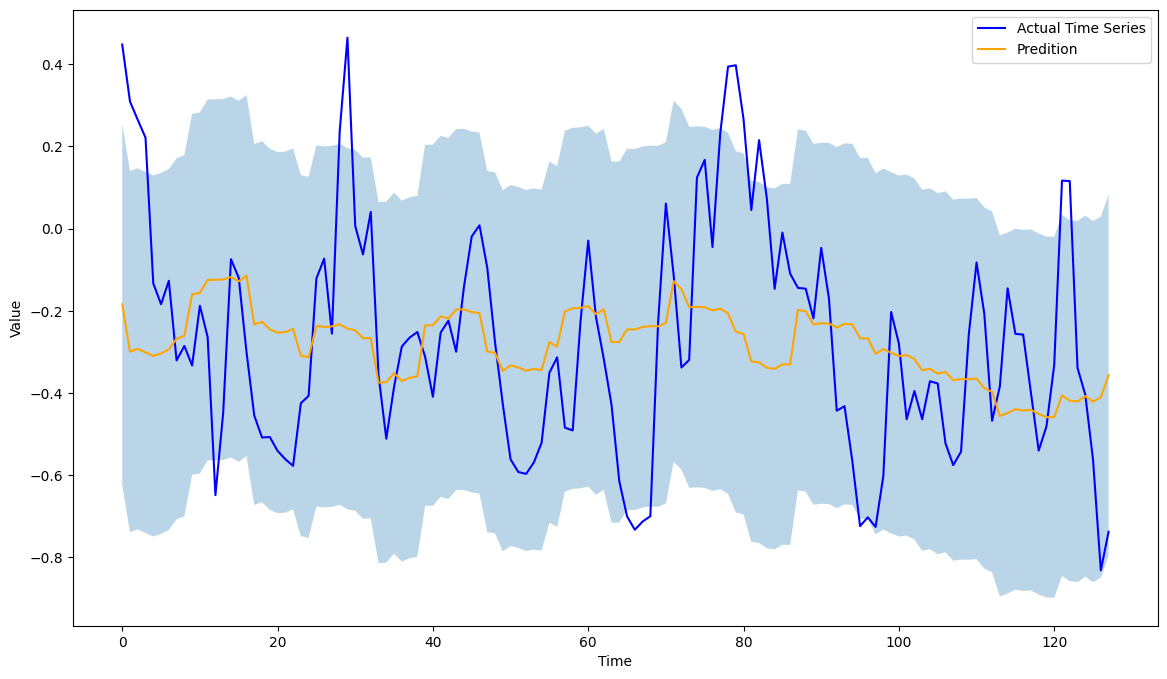

In [ ]:
model.eval()
with torch.no_grad():
    i = np.random.randint(0, len(val_dataset))
    series = val_dataset[i][0].unsqueeze(0)
    pred = model(val_dataset[i][0].unsqueeze(0))
    # plot the time series
plot_time_series_with_errors_area(series.squeeze().numpy(), pred.squeeze().numpy(), pred.squeeze().numpy()+model.threshold, pred.squeeze().numpy()-model.threshold)

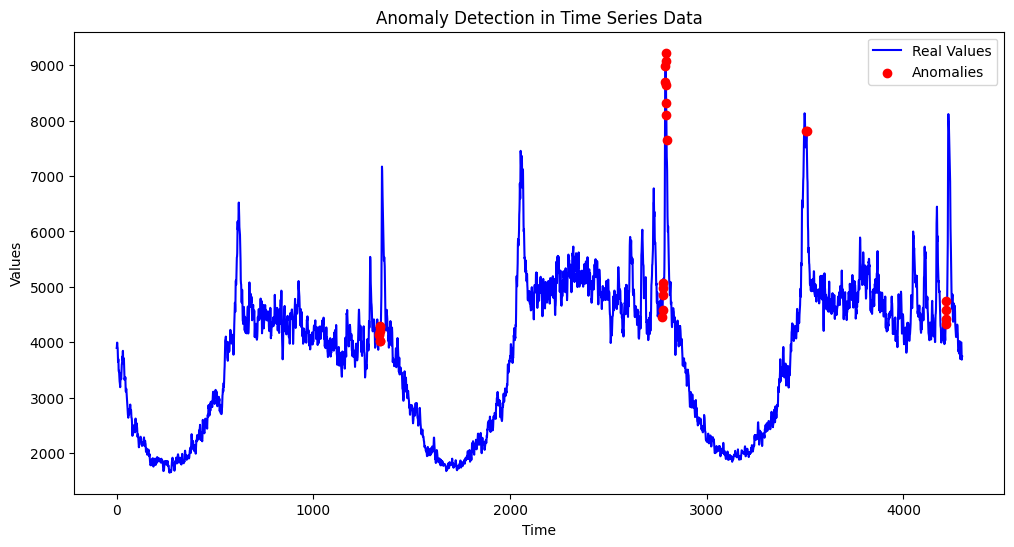

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train and y_train are your data tensors
# Example:
# x_train = torch.randn(1000, 10, 10)  # 1000 samples, sequence length 10, 10 features each
# y_train = torch.randn(1000, 10, 10)  # 1000 samples, sequence length 10, 10 targets each

# Define a function to analyze the time series using the model
def detect_anomalies(model, time_series, threshold, window_size):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    predicted_values = []
    with torch.no_grad():  # Disable gradient calculation
        for i in range(0, len(time_series) - window_size + 1, window_size):
            window = time_series[i:i + window_size].unsqueeze(0)  # Add batch dimension
            prediction = model(window).squeeze(0)
            predicted_values.extend(prediction.tolist())

            error = torch.abs(prediction - window.squeeze(0))
            for j in range(window_size):
                if error[j].item() > threshold:
                    anomalies.append(i + j)  # Mark the specific point as an anomaly
    return anomalies, predicted_values

# Example time series data (replace with your actual data)
time_series_data = data['value'].values[0:4300].reshape(-1, 1)  # Replace with your actual time series data
deseasonalized = torch.FloatTensor(scaler.transform(data['de_seasonalized'].values[0:4300].reshape(-1, 1)))
window_size = SEQ_LEN  # Replace with your actual window size
threshold = model.threshold*10  # Replace with your actual threshold for anomaly detection

# Detect anomalies
anomalies, predicted_values = detect_anomalies(model, deseasonalized, threshold, window_size)

# Convert lists to numpy arrays for easier plotting
predicted_values = np.array(predicted_values).flatten()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Real Values', color='blue')
plt.scatter(anomalies, time_series_data[anomalies], color='red', label='Anomalies', zorder=5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Anomaly Detection in Time Series Data')
plt.show()


In [418]:
save_checkpoint(model=model, scaler=scaler, threshold=model.threshold*10, path='throughput_model.pth')

Checkpoint saved at epoch


LSTM TRAINING

In [214]:
import torch
import torch.nn as nn

class LSTMModel(pl.LightningModule):
    def __init__(self, input_dim, seq_len, hidden_dim=128, dropout_rate=0.2, loss=nn.L1Loss()):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.input_dim = input_dim
        
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.repeat_vector = lambda x: x.unsqueeze(1).repeat(1, self.seq_len, 1)
        
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.time_distributed_dense = nn.Linear(hidden_dim, input_dim)
        self.loss = loss

    def forward(self, x):
        # LSTM layer
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        # RepeatVector
        x = self.repeat_vector(x[:, -1, :])
        
        # LSTM layer
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        # TimeDistributed Dense layer
        x = self.time_distributed_dense(x)
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        y_pred = self(x)
        loss = self.loss(y_pred, x)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer
    
    # Function to evaluate model on validation set
    def evaluate_threshhold(self, val_loader, percentile):
        self.eval()  # Set model to evaluation mode
        val_loss = []
        criterion = nn.L1Loss()
        with torch.no_grad():  # Disable gradient calculation
            for x, y in val_loader:
                y_hat = self(x)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
        THRESHOLD = np.percentile(val_loss, percentile)
        self.threshold = THRESHOLD
        return THRESHOLD


array([3898. , 3917.5, 3993. , ..., 2429. , 2373.5, 1170. ])

In [223]:
scaler = get_scaler(data['value'].values)
dataset, train_dataloader, val_dataloader = create_dataloader(data['value'].values, scaler, 20, 0.8)

In [225]:
# Instantiate the model
model = LSTMModel(input_dim=1, hidden_dim=128, seq_len=20)
# Initialize EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=0,          # Number of epochs with no improvement to stop training
    verbose=True,        # Enable verbose mode
    mode='min'           # Mode 'min' to stop when the metric stops decreasing
)
# Initialize ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',      # Metric to monitor
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Filename for the best checkpoint
    save_top_k=1,            # Save only the best checkpoint
    mode='min',              # Mode 'min' to save the checkpoint with the lowest 'val_loss'
    save_last=True,          # Save the final model
    verbose=True
)
checkpoint_callback = ModelCheckpoint('./')
trainer = pl.Trainer(max_epochs=2, logger=True, log_every_n_steps=1, val_check_interval=100, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type    | Params
---------------------------------------------------
0 | lstm1                  | LSTM    | 67.1 K
1 | dropout1               | Dropout | 0     
2 | lstm2                  | LSTM    | 132 K 
3 | dropout2               | Dropout | 0     
4 | time_distributed_dense | Linear  | 129   
5 | loss                   | L1Loss  | 0     
---------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 87.72it/s]

d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   9%|▉         | 100/1082 [00:02<00:24, 40.56it/s, v_num=47, train_loss_step=0.237]

Metric val_loss improved. New best score: 0.259


Epoch 0:  18%|█▊        | 200/1082 [00:08<00:36, 24.18it/s, v_num=47, train_loss_step=0.168, val_loss_step=0.268, val_loss_epoch=0.259]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 0.181


Epoch 0:  28%|██▊       | 300/1082 [00:14<00:36, 21.18it/s, v_num=47, train_loss_step=0.172, val_loss_step=0.137, val_loss_epoch=0.181]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.159


Epoch 0:  37%|███▋      | 400/1082 [00:20<00:34, 19.82it/s, v_num=47, train_loss_step=0.195, val_loss_step=0.198, val_loss_epoch=0.159]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.154


Epoch 0:  46%|████▌     | 500/1082 [00:26<00:31, 18.71it/s, v_num=47, train_loss_step=0.188, val_loss_step=0.110, val_loss_epoch=0.154]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.152


Epoch 0:  55%|█████▌    | 600/1082 [00:33<00:26, 18.14it/s, v_num=47, train_loss_step=0.155, val_loss_step=0.165, val_loss_epoch=0.152]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.147


Epoch 0:  65%|██████▍   | 700/1082 [00:40<00:21, 17.38it/s, v_num=47, train_loss_step=0.174, val_loss_step=0.0837, val_loss_epoch=0.147]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.147


Epoch 0:  74%|███████▍  | 800/1082 [00:47<00:16, 16.84it/s, v_num=47, train_loss_step=0.121, val_loss_step=0.134, val_loss_epoch=0.147] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.144


Epoch 0:  83%|████████▎ | 900/1082 [00:54<00:10, 16.67it/s, v_num=47, train_loss_step=0.148, val_loss_step=0.128, val_loss_epoch=0.144] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.143


Epoch 0:  92%|█████████▏| 1000/1082 [01:01<00:05, 16.30it/s, v_num=47, train_loss_step=0.106, val_loss_step=0.397, val_loss_epoch=0.143]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.142


Epoch 1:   9%|▉         | 100/1082 [00:02<00:25, 38.33it/s, v_num=47, train_loss_step=0.136, val_loss_step=0.126, val_loss_epoch=0.142, train_loss_epoch=0.211] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.140


Epoch 1:  18%|█▊        | 200/1082 [00:09<00:40, 21.89it/s, v_num=47, train_loss_step=0.199, val_loss_step=0.116, val_loss_epoch=0.140, train_loss_epoch=0.211]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.139


Epoch 1:  28%|██▊       | 300/1082 [00:15<00:40, 19.45it/s, v_num=47, train_loss_step=0.185, val_loss_step=0.102, val_loss_epoch=0.139, train_loss_epoch=0.211] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.139


Epoch 1:  37%|███▋      | 400/1082 [00:22<00:37, 17.98it/s, v_num=47, train_loss_step=0.105, val_loss_step=0.0912, val_loss_epoch=0.139, train_loss_epoch=0.211] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.139


Epoch 1:  46%|████▌     | 500/1082 [00:28<00:33, 17.35it/s, v_num=47, train_loss_step=0.166, val_loss_step=0.138, val_loss_epoch=0.139, train_loss_epoch=0.211] 

Monitored metric val_loss did not improve in the last 1 records. Best score: 0.139. Signaling Trainer to stop.


Epoch 1:  46%|████▌     | 500/1082 [00:32<00:38, 15.29it/s, v_num=47, train_loss_step=0.166, val_loss_step=0.121, val_loss_epoch=0.143, train_loss_epoch=0.151]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1:  46%|████▌     | 500/1082 [00:32<00:38, 15.29it/s, v_num=47, train_loss_step=0.166, val_loss_step=0.121, val_loss_epoch=0.143, train_loss_epoch=0.151]
